In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

In [2]:
dataset = pd.read_csv("/Users/MACOS/Desktop/Data_Analytics/Walmart_Price_Predictor/Walmart_Sales_and_Pricing/Train.csv")
apply =  pd.read_csv("/Users/MACOS/Desktop/Data_Analytics/Walmart_Price_Predictor/Walmart_Sales_and_Pricing/Test.csv")

#print(train.head())
#print(test.head())

In [3]:
dataset.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
#from sklearn.model_selection import train_test_split

#train ,test = train_test_split(dataset,test_size=0.4)       #test_size=0.5(whole_data)
    

In [4]:
#I. EDA
types = dataset.dtypes
print(types)
print("Shape of the set is: ", dataset.shape)



Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object
Shape of the set is:  (8523, 12)


In [5]:
#I.1. Explore
print("The statistic of numeric data")
print("Name \t\t   Mean \t Median \t ")
for i in dataset.columns:
    if(dataset[i].dtype == "float64"):
        print(i, "\t %.2f \t  %.2f" % \
              (np.mean(dataset[i]), np.median(dataset[i])) )


        

The statistic of numeric data
Name 		   Mean 	 Median 	 
Item_Weight 	 12.86 	  nan
Item_Visibility 	 0.07 	  0.05
Item_MRP 	 140.99 	  143.01
Item_Outlet_Sales 	 2181.29 	  1794.33


Item_Identifier             : Is primary key, will keep this
Item_Weight                 : Weight per product in grams
Item_Fat_Content              object
Item_Visibility             : I could not find information on what metric this is. Assuming people can optimize this, we'll include it in our analysis. Possible sources?: https://www.researchgate.net/publication/273279491_Developing_visibility_analysis_for_a_retail_store_A_pilot_study_in_a_bookstore
Item_Type                     object
Item_MRP                     : Item's Maximum Retail Price
Outlet_Identifier            : I doubt this will be useful for someone predicting sales for a new item in another specific outlet. Will delete this.
Outlet_Establishment_Year    : Will also delete this, for the same reason.
Outlet_Size                  : Please see other references of what Walmart considers to be a big/ medium / small size
Outlet_Location_Type         : Same as for Size
Outlet_Type                  : Same as for Type
Item_Outlet_Sales            : We're looking to predict this

In [6]:
#I.2. Cleaning
#a. Dropping Duplicates
duplicaterows = dataset[dataset.duplicated()]
print("Dataset's duplicates:", duplicaterows.shape)
if duplicaterows.shape[0]==0:
    print("There is no duplicate rows")
else:
    dataset = dataset.drop_duplicates()

    

Dataset's duplicates: (0, 12)
There is no duplicate rows


In [7]:
#b. Dropping missing values
print("Training set's missing values:")
print(dataset.isnull().sum())
#num_missing = (df['Confirmed'] == 0).sum()
dataset['Item_Weight'] = dataset['Item_Weight'].fillna(dataset['Item_Weight'].mean()) #Replacing the missing data witht the mean of the rest
#df = df.dropna() # Dropping NA values


Training set's missing values:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


I expect the size to have an effect on the final sales of the product, since size suggests larger selection pool, and thus Analysis Paralysis. Therefore we will not delete 1/8 of the dataset where Outlet Size is missing.
Also, whatever Visibility is, I doubt any item on sales has the visibilty of zero. Thus, we would replace the 0s with the mean of the rest as well.

In [8]:
mean = 0
number_of_nonzeroes = 0
for i in dataset['Item_Visibility']:
    if(i != 0):
        number_of_nonzeroes+=1
    mean = mean + i
mean_of_nonzeroes = mean/number_of_nonzeroes
print("The mean of the non-zero cells is: ", mean_of_nonzeroes)
dataset['Item_Visibility'] = dataset['Item_Visibility'].replace(0,mean_of_nonzeroes)


The mean of the non-zero cells is:  0.07048184085069421


In [9]:
#Removing columns
dataset = dataset.drop(['Item_Identifier','Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size'], axis=1)



In [10]:
dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].replace("LF","Low Fat")
dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].replace("low fat","Low Fat")
dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].replace("reg","Regular")


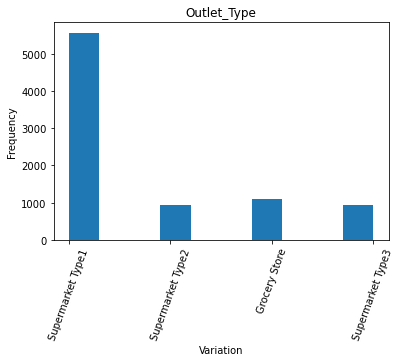

In [12]:
#I.3. Drawing graphs to explore and modify
#a. Histograms
i = "Outlet_Type"
#Input Item_Fat_Content Item_Type Outlet_Location_Type Outlet_Type
#for i in train.columns:
 #   if(str(train[i].dtypes) == "object" and str(i) != "Item_Identifier" and str(i) != "Outlet_Size"):
p = plt.hist(dataset[i])
plt.xlabel('Variation')
plt.ylabel('Frequency')
plt.tick_params(axis ='x', rotation = 70) 
plt.title(i)
plt.show()

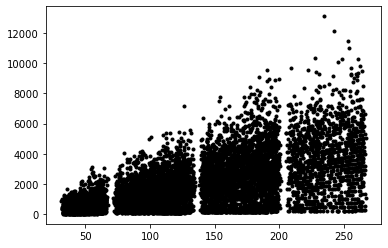

In [13]:
#b. Scatter plot
i = "Item_MRP"
#Input Item_Weight Item_MRP
plt.plot(dataset[i], dataset["Item_Outlet_Sales"], '.', color='black');


In [14]:
print(dataset)

      Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
0           9.300          Low Fat         0.016047                  Dairy   
1           5.920          Regular         0.019278            Soft Drinks   
2          17.500          Low Fat         0.016760                   Meat   
3          19.200          Regular         0.070482  Fruits and Vegetables   
4           8.930          Low Fat         0.070482              Household   
...           ...              ...              ...                    ...   
8518        6.865          Low Fat         0.056783            Snack Foods   
8519        8.380          Regular         0.046982           Baking Goods   
8520       10.600          Low Fat         0.035186     Health and Hygiene   
8521        7.210          Regular         0.145221            Snack Foods   
8522       14.800          Low Fat         0.044878            Soft Drinks   

      Item_MRP Outlet_Location_Type        Outlet_Type  Item_Ou

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
#One hot encoder: Fat content
# importing one hot encoder 
from sklearn.preprocessing import OneHotEncoder
#creating one hot encoder object 
onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(dataset.Item_Fat_Content.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["FatContent: "+str(int(i)) for i in range(2)]) 
df = pd.concat([dataset, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['Item_Fat_Content'], axis=1) 
#printing to verify 
print(df.head())

   Item_Weight  Item_Visibility              Item_Type  Item_MRP  \
0         9.30         0.016047                  Dairy  249.8092   
1         5.92         0.019278            Soft Drinks   48.2692   
2        17.50         0.016760                   Meat  141.6180   
3        19.20         0.070482  Fruits and Vegetables  182.0950   
4         8.93         0.070482              Household   53.8614   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  FatContent: 0  \
0               Tier 1  Supermarket Type1          3735.1380            1.0   
1               Tier 3  Supermarket Type2           443.4228            0.0   
2               Tier 1  Supermarket Type1          2097.2700            1.0   
3               Tier 3      Grocery Store           732.3800            0.0   
4               Tier 3  Supermarket Type1           994.7052            1.0   

   FatContent: 1  
0            0.0  
1            1.0  
2            0.0  
3            1.0  
4            0.0  


In [24]:
#One hot encoder: Outlet_Location_Type
#creating one hot encoder object 
#onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df.Outlet_Location_Type.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["Outlet_Location_Type: "+str(int(i)) for i in range(3)]) 
df = pd.concat([df, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['Outlet_Location_Type'], axis=1) 
#printing to verify 
print(df.head())

   Item_Weight  Item_Visibility              Item_Type  Item_MRP  \
0         9.30         0.016047                  Dairy  249.8092   
1         5.92         0.019278            Soft Drinks   48.2692   
2        17.50         0.016760                   Meat  141.6180   
3        19.20         0.070482  Fruits and Vegetables  182.0950   
4         8.93         0.070482              Household   53.8614   

         Outlet_Type  Item_Outlet_Sales  FatContent: 0  FatContent: 1  \
0  Supermarket Type1          3735.1380            1.0            0.0   
1  Supermarket Type2           443.4228            0.0            1.0   
2  Supermarket Type1          2097.2700            1.0            0.0   
3      Grocery Store           732.3800            0.0            1.0   
4  Supermarket Type1           994.7052            1.0            0.0   

   Outlet_Location_Type: 0  Outlet_Location_Type: 1  Outlet_Location_Type: 2  
0                      1.0                      0.0                      

In [26]:
#One hot encoder: Outlet_Location_Type
#creating one hot encoder object 
#onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df.Outlet_Type.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["Outlet_Type: "+str(int(i)) for i in range(4)]) 
df = pd.concat([df, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['Outlet_Type'], axis=1) 
#printing to verify 
print(df.head())

   Item_Weight  Item_Visibility              Item_Type  Item_MRP  \
0         9.30         0.016047                  Dairy  249.8092   
1         5.92         0.019278            Soft Drinks   48.2692   
2        17.50         0.016760                   Meat  141.6180   
3        19.20         0.070482  Fruits and Vegetables  182.0950   
4         8.93         0.070482              Household   53.8614   

   Item_Outlet_Sales  FatContent: 0  FatContent: 1  Outlet_Location_Type: 0  \
0          3735.1380            1.0            0.0                      1.0   
1           443.4228            0.0            1.0                      0.0   
2          2097.2700            1.0            0.0                      1.0   
3           732.3800            0.0            1.0                      0.0   
4           994.7052            1.0            0.0                      0.0   

   Outlet_Location_Type: 1  Outlet_Location_Type: 2  Outlet_Type: 0  \
0                      0.0                   

In [28]:
#One hot encoder: Item_Type
#creating one hot encoder object 
#onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df.Item_Type.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["Item_Type: "+str(int(i)) for i in range(16)]) 
df = pd.concat([df, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['Item_Type'], axis=1) 
#printing to verify 
print(df.head())

   Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales  FatContent: 0  \
0         9.30         0.016047  249.8092          3735.1380            1.0   
1         5.92         0.019278   48.2692           443.4228            0.0   
2        17.50         0.016760  141.6180          2097.2700            1.0   
3        19.20         0.070482  182.0950           732.3800            0.0   
4         8.93         0.070482   53.8614           994.7052            1.0   

   FatContent: 1  Outlet_Location_Type: 0  Outlet_Location_Type: 1  \
0            0.0                      1.0                      0.0   
1            1.0                      0.0                      0.0   
2            0.0                      1.0                      0.0   
3            1.0                      0.0                      0.0   
4            0.0                      0.0                      0.0   

   Outlet_Location_Type: 2  Outlet_Type: 0  ...  Item_Type: 6  Item_Type: 7  \
0                      0.

In [33]:
from sklearn.model_selection import train_test_split

train ,test = train_test_split(df,test_size=0.4)       #test_size=0.5(whole_data)
    

In [34]:
#II. Decision tree regressor
#Spliting the training dataset
X = train.drop(['Item_Outlet_Sales'], axis = 1)
Y = train['Item_Outlet_Sales']

In [35]:
print(Y)

6776     482.0392
2387    1179.1318
1542    1605.9096
3426    2535.3664
8225    2588.6304
          ...    
519     5344.3766
7376    2399.5432
7834    1133.8574
6552    2082.6224
5777     335.5632
Name: Item_Outlet_Sales, Length: 5113, dtype: float64


In [36]:
regr_1 = DecisionTreeRegressor(criterion='friedman_mse',\
                               max_depth=60, min_samples_split=2\
                                ,min_samples_leaf=1, min_weight_fraction_leaf=0.0, \
                               max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, \
                               min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)
regr_2 = DecisionTreeRegressor(criterion='mse', splitter='best',\
                               max_depth=None, min_samples_split=20\
                                ,min_samples_leaf=1, min_weight_fraction_leaf=0.0, \
                               max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, \
                               min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)
regr_1.fit(X, Y)
regr_2.fit(X, Y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [37]:
# Predict
X_test = test.drop(['Item_Outlet_Sales'], axis = 1)
Y_test = test['Item_Outlet_Sales']
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

In [42]:
print(Y_test)

785      966.7416
1409    5697.9164
1370    5954.2494
328     3340.9844
7162    2061.3168
          ...    
8246    4673.9160
2812     617.8624
6941    3504.7712
3598     218.3824
5387    2157.1920
Name: Item_Outlet_Sales, Length: 3410, dtype: float64


In [43]:
print(y_1)
print(len(y_1))

[1267.6832 3349.6398 4195.8716 ... 5359.69    316.255  2886.243 ]
3410


In [39]:
print(y_2)

[1489.59434    4196.05318182 4005.67473333 ... 2714.41111667  177.48325714
 3311.74041538]
